# Channel Head Coupling Analysis - Experiment Template

This notebook provides a clean template for running analysis experiments with different parameters.

**Key features:**
- All experiment parameters defined in one cell
- Outputs automatically organized by experiment name/threshold
- Easy to duplicate for new experiments

## How to use:
1. **Duplicate this notebook** for each experiment (e.g., `experiment_th500.ipynb`)
2. **Modify the parameters** in the "Experiment Configuration" cell below
3. **Run all cells** to execute the analysis
4. Results are saved to `data/outputs/experiments/{EXPERIMENT_NAME}/`

---
## Experiment Configuration

**Modify these parameters for your experiment:**

In [1]:
# ============================================================================
# EXPERIMENT PARAMETERS - MODIFY THESE FOR YOUR EXPERIMENT
# ============================================================================

# Experiment identification
EXPERIMENT_NAME = "th500_test"  # Unique name for this experiment
EXPERIMENT_NOTES = "Testing higher stream threshold (500 vs default 145)"

# Stream extraction threshold (default in paper: 145)
# Higher = fewer, larger streams; Lower = more, smaller streams
STREAM_THRESHOLD = 500

# Basins to analyze (set to None for all 18 basins)
# Examples:
#   BASINS_TO_RUN = None  # All 18 basins
#   BASINS_TO_RUN = ["inyo", "humboldt"]  # Just these two
#   BASINS_TO_RUN = ["inyo"]  # Single basin for quick test
BASINS_TO_RUN = None # Quick test set

# Limit outlets per basin (None = all outlets, useful for quick tests)
MAX_OUTLETS_PER_BASIN = None

# Connectivity for coupling detection (4 or 8)
# 8 = include diagonal neighbors (more sensitive)
# 4 = only cardinal directions (more conservative)
CONNECTIVITY = 8

# ============================================================================
print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Notes: {EXPERIMENT_NOTES}")
print(f"Stream threshold: {STREAM_THRESHOLD}")
print(f"Basins: {BASINS_TO_RUN or 'All 18'}")
print(f"Max outlets per basin: {MAX_OUTLETS_PER_BASIN or 'All'}")
print(f"Connectivity: {CONNECTIVITY}")

Experiment: th500_test
Notes: Testing higher stream threshold (500 vs default 145)
Stream threshold: 500
Basins: All 18
Max outlets per basin: All
Connectivity: 8


---
## Setup and Imports

In [2]:
import sys
import pathlib
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import topotoolbox as tt3

# Add project root so "channel_heads" package is visible
project_root = pathlib.Path("/Users/guypi/Projects/channel-heads")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Core analysis imports
from channel_heads import (
    CouplingAnalyzer,
    first_meet_pairs_for_outlet,
    outlet_node_ids_from_streampoi,
    # Lengthwise asymmetry
    LengthwiseAsymmetryAnalyzer,
    compute_asymmetry_statistics,
    merge_coupling_and_asymmetry,
    # Basin configuration
    get_z_th,
    get_basin_config,
    get_reference_delta_L,
    BASIN_CONFIG,
    # Path management
    CROPPED_DEMS_DIR,
    get_experiment_output_dir,
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
%matplotlib inline

# Create output directory for this experiment
OUTPUT_DIR = get_experiment_output_dir(EXPERIMENT_NAME)
print(f"\nOutput directory: {OUTPUT_DIR}")
print("Setup complete!")


Output directory: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th500_test
Setup complete!


---
## Basin Configuration

In [3]:
# All 18 basins from Goren & Shelef (2024)
ALL_BASINS = {
    "inyo": {"dem_path": CROPPED_DEMS_DIR / "Inyo_strm_crop.tif", "paper_name": "inyo"},
    "humboldt": {"dem_path": CROPPED_DEMS_DIR / "Humboldt_strm_crop.tif", "paper_name": "humboldt"},
    "calnalpine": {"dem_path": CROPPED_DEMS_DIR / "CalnAlpine_strm_crop.tif", "paper_name": "clanalpine"},
    "daqing": {"dem_path": CROPPED_DEMS_DIR / "Daqing_strm_crop.tif", "paper_name": "daqing"},
    "kammanasie": {"dem_path": CROPPED_DEMS_DIR / "Kammanasie_strm_crop.tif", "paper_name": "kammanassie"},
    "luliang": {"dem_path": CROPPED_DEMS_DIR / "Luliang_strm_crop.tif", "paper_name": "luliang"},
    "finisterre": {"dem_path": CROPPED_DEMS_DIR / "Finisterre_strm_crop.tif", "paper_name": "finisterre"},
    "taiwan": {"dem_path": CROPPED_DEMS_DIR / "Taiwan_strm_crop.tif", "paper_name": "taiwan"},
    "panamint": {"dem_path": CROPPED_DEMS_DIR / "Panamint_strm_crop.tif", "paper_name": "panamint"},
    "sakhalin": {"dem_path": CROPPED_DEMS_DIR / "Sakhalin_strm_crop.tif", "paper_name": "sakhalin"},
    "vallefertil": {"dem_path": CROPPED_DEMS_DIR / "ValleFertil_strm_crop.tif", "paper_name": "vallefertil"},
    "sierramadre": {"dem_path": CROPPED_DEMS_DIR / "SierraMadre_strm_crop.tif", "paper_name": "sierramadre"},
    "sierranevadaspain": {"dem_path": CROPPED_DEMS_DIR / "SierraNevadaSpain_strm_crop.tif", "paper_name": "sierranevada_spain"},
    "piedepalo": {"dem_path": CROPPED_DEMS_DIR / "PieDePalo_strm_crop.tif", "paper_name": "piedepalo"},
    "toano": {"dem_path": CROPPED_DEMS_DIR / "Toano_strm_crop.tif", "paper_name": "toano"},
    "troodos": {"dem_path": CROPPED_DEMS_DIR / "Troodos_strm_crop.tif", "paper_name": "troodos"},
    "tsugaru": {"dem_path": CROPPED_DEMS_DIR / "Tsugaru_strm_crop.tif", "paper_name": "tsugaru"},
    "yoro": {"dem_path": CROPPED_DEMS_DIR / "Yoro_strm_crop.tif", "paper_name": "yoro"},
}

# Filter to selected basins
if BASINS_TO_RUN is not None:
    BASINS_TO_ANALYZE = {k: v for k, v in ALL_BASINS.items() if k in BASINS_TO_RUN}
else:
    BASINS_TO_ANALYZE = ALL_BASINS

# Show basin configurations
print("=" * 80)
print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Stream threshold: {STREAM_THRESHOLD}")
print(f"Basins to analyze: {len(BASINS_TO_ANALYZE)}")
print("=" * 80)

for name, config in BASINS_TO_ANALYZE.items():
    basin_config = get_basin_config(config["paper_name"])
    dem_exists = config['dem_path'].exists()
    status = "OK" if dem_exists else "MISSING"
    print(f"  {basin_config['full_name'][:40]:<40} z_th={basin_config['z_th']:>4}m [{status}]")

Experiment: th500_test
Stream threshold: 500
Basins to analyze: 18
  Inyo Mountains, California               z_th=1200m [OK]
  Humboldt Range, Nevada                   z_th=1450m [OK]
  Clan Alpine Mountains, Nevada            z_th=1700m [OK]
  Daquing Shan, China                      z_th=1200m [OK]
  Kammanassie Mountains, South Africa      z_th= 630m [OK]
  Lüliang Mountains, China                 z_th=1100m [OK]
  Finisterre Range, Papua New Guinea       z_th= 400m [OK]
  Central Mountain Range, Taiwan           z_th=  80m [OK]
  Panamint Range, California               z_th= 800m [OK]
  Sakhalin Mountains, Russia               z_th=  60m [OK]
  Sierra del Valle Fértil, Argentina       z_th=1050m [MISSING]
  Sierra Madre del Sur, Mexico             z_th= 380m [OK]
  Sierra Nevada, Spain                     z_th=1200m [OK]
  Sierra Pie de Palo, Argentina            z_th= 650m [MISSING]
  Toano Range, Nevada                      z_th=1710m [OK]
  Troodos Mountains, Cyprus           

---
## Analysis Functions

In [4]:
def load_and_prepare_basin(basin_name, dem_path, z_th, stream_threshold):
    """Load DEM, apply z_th mask, and create stream network."""
    print(f"Loading {basin_name}...")
    
    # Load DEM
    dem = tt3.read_tif(str(dem_path))
    print(f"  DEM shape: {dem.z.shape}")
    print(f"  Elevation range: {np.nanmin(dem.z):.0f} - {np.nanmax(dem.z):.0f} m")
    
    # Apply z_th mask
    dem.z[dem.z < z_th] = np.nan
    valid_pct = 100 * np.sum(~np.isnan(dem.z)) / dem.z.size
    print(f"  Applied z_th={z_th} m mask: {valid_pct:.1f}% valid pixels")
    
    # Create flow and stream objects
    fd = tt3.FlowObject(dem)
    s = tt3.StreamObject(fd, threshold=stream_threshold)
    
    # Count network features
    n_outlets = np.sum(s.streampoi('outlets'))
    n_heads = np.sum(s.streampoi('channelheads'))
    n_confluences = np.sum(s.streampoi('confluences'))
    print(f"  Stream network (threshold={stream_threshold}):")
    print(f"    Outlets: {n_outlets}, Heads: {n_heads}, Confluences: {n_confluences}")
    
    return {"dem": dem, "fd": fd, "s": s}


def run_full_analysis(s, fd, dem, lat, connectivity, max_outlets=None):
    """Run coupling + lengthwise asymmetry analysis for all outlets."""
    outlets = outlet_node_ids_from_streampoi(s)
    outlets = [int(o) for o in outlets]
    
    if max_outlets and len(outlets) > max_outlets:
        print(f"  Limiting to first {max_outlets} outlets (of {len(outlets)})")
        outlets = outlets[:max_outlets]
    
    # Create analyzers
    coupling_an = CouplingAnalyzer(fd, s, dem, connectivity=connectivity)
    asymmetry_an = LengthwiseAsymmetryAnalyzer(s, dem, lat=lat)
    
    coupling_dfs = []
    asymmetry_dfs = []
    
    for idx, outlet in enumerate(outlets, 1):
        print(f"  [{idx}/{len(outlets)}] outlet={outlet}", end="", flush=True)
        
        pairs_at_confluence, basin_heads = first_meet_pairs_for_outlet(s, outlet)
        
        if not pairs_at_confluence:
            print(" (no pairs)")
            continue
        
        # Clear caches between outlets
        coupling_an.clear_cache()
        asymmetry_an.clear_cache()
        
        df_coupling = coupling_an.evaluate_pairs_for_outlet(outlet, pairs_at_confluence)
        df_asymmetry = asymmetry_an.evaluate_pairs_for_outlet(outlet, pairs_at_confluence)
        
        n_pairs = len(df_coupling)
        n_touching = df_coupling['touching'].sum() if not df_coupling.empty else 0
        print(f" ({n_pairs} pairs, {n_touching} touching)")
        
        if not df_coupling.empty:
            coupling_dfs.append(df_coupling)
        if not df_asymmetry.empty:
            asymmetry_dfs.append(df_asymmetry)
    
    if not coupling_dfs:
        return pd.DataFrame()
    
    df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)
    df_asymmetry_all = pd.concat(asymmetry_dfs, ignore_index=True)
    df_combined = merge_coupling_and_asymmetry(df_coupling_all, df_asymmetry_all)
    df_combined.sort_values(["outlet", "confluence", "head_1", "head_2"], inplace=True, ignore_index=True)
    
    return df_combined

---
## Run Analysis

In [5]:
# Store results
basin_results = {}
basin_data = {}

# Save experiment metadata
metadata = {
    "experiment_name": EXPERIMENT_NAME,
    "experiment_notes": EXPERIMENT_NOTES,
    "stream_threshold": STREAM_THRESHOLD,
    "connectivity": CONNECTIVITY,
    "max_outlets_per_basin": MAX_OUTLETS_PER_BASIN,
    "basins": list(BASINS_TO_ANALYZE.keys()),
    "timestamp": datetime.now().isoformat(),
}

import json
with open(OUTPUT_DIR / "experiment_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)
print(f"Saved experiment metadata to: {OUTPUT_DIR / 'experiment_metadata.json'}")

print("\n" + "=" * 80)

for basin_name, config in BASINS_TO_ANALYZE.items():
    if not config["dem_path"].exists():
        print(f"\nSkipping {basin_name}: DEM not found")
        continue
    
    print("\n" + "=" * 80)
    print(f"Processing: {basin_name.upper()}")
    print("=" * 80)
    
    basin_config = get_basin_config(config["paper_name"])
    z_th = basin_config["z_th"]
    lat = basin_config["lat"]
    
    # Load and prepare
    data = load_and_prepare_basin(
        basin_name=basin_name,
        dem_path=config["dem_path"],
        z_th=z_th,
        stream_threshold=STREAM_THRESHOLD,
    )
    basin_data[basin_name] = data
    
    # Run analysis
    print(f"\nRunning analysis (connectivity={CONNECTIVITY})...")
    df_results = run_full_analysis(
        s=data["s"],
        fd=data["fd"],
        dem=data["dem"],
        lat=lat,
        connectivity=CONNECTIVITY,
        max_outlets=MAX_OUTLETS_PER_BASIN,
    )
    basin_results[basin_name] = df_results
    
    # Save per-basin results
    output_path = OUTPUT_DIR / f"{basin_name}_results.csv"
    df_results.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")

print("\n" + "=" * 80)
print(f"Analysis complete! Results in: {OUTPUT_DIR}")
print("=" * 80)

Saved experiment metadata to: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th500_test/experiment_metadata.json


Processing: INYO
Loading inyo...
  DEM shape: (289, 284)
  Elevation range: 329 - 3363 m
  Applied z_th=1200 m mask: 65.4% valid pixels
  Stream network (threshold=500):
    Outlets: 25, Heads: 30, Confluences: 5

Running analysis (connectivity=8)...
  [1/25] outlet=1 (no pairs)
  [2/25] outlet=2 (no pairs)
  [3/25] outlet=3 (no pairs)
  [4/25] outlet=4 (no pairs)
  [5/25] outlet=5 (no pairs)
  [6/25] outlet=32 (no pairs)
  [7/25] outlet=63 (1 pairs, 1 touching)
  [8/25] outlet=119 (no pairs)
  [9/25] outlet=197 (no pairs)
  [10/25] outlet=227 (1 pairs, 0 touching)
  [11/25] outlet=260 (no pairs)
  [12/25] outlet=335 (no pairs)
  [13/25] outlet=384 (no pairs)
  [14/25] outlet=404 (no pairs)
  [15/25] outlet=661 (no pairs)
  [16/25] outlet=782 (1 pairs, 0 touching)
  [17/25] outlet=824 (1 pairs, 0 touching)
  [18/25] outlet=876 (no pairs)
  [19/25] outlet=892 

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_78175/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


 (3 pairs, 1 touching)
  [34/46] outlet=2063 (15 pairs, 3 touching)
  [35/46] outlet=2267 (no pairs)
  [36/46] outlet=2307 (no pairs)
  [37/46] outlet=2313 (no pairs)
  [38/46] outlet=2378 (no pairs)
  [39/46] outlet=2385 (no pairs)
  [40/46] outlet=2490 (no pairs)
  [41/46] outlet=2510 (6 pairs, 0 touching)
  [42/46] outlet=2575 (no pairs)
  [43/46] outlet=2623 (no pairs)
  [44/46] outlet=2662 (no pairs)
  [45/46] outlet=2689 (no pairs)
  [46/46] outlet=2690 (no pairs)
Saved: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th500_test/luliang_results.csv

Processing: FINISTERRE
Loading finisterre...
  DEM shape: (943, 1674)
  Elevation range: 0 - 4096 m
  Applied z_th=400 m mask: 71.3% valid pixels


/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_78175/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


  Stream network (threshold=500):
    Outlets: 137, Heads: 602, Confluences: 464

Running analysis (connectivity=8)...
  [1/137] outlet=0 (36 pairs, 6 touching)
  [2/137] outlet=1 (no pairs)
  [3/137] outlet=33 (3 pairs, 0 touching)
  [4/137] outlet=59 (no pairs)
  [5/137] outlet=283 (3 pairs, 0 touching)
  [6/137] outlet=542 (no pairs)
  [7/137] outlet=644 (no pairs)
  [8/137] outlet=691 (no pairs)
  [9/137] outlet=1058 (no pairs)
  [10/137] outlet=1092 (1 pairs, 1 touching)
  [11/137] outlet=1096 (3 pairs, 0 touching)
  [12/137] outlet=1444 (no pairs)
  [13/137] outlet=1778 (no pairs)
  [14/137] outlet=1867 (861 pairs, 16 touching)
  [15/137] outlet=1937 (no pairs)
  [16/137] outlet=1938 (6 pairs, 1 touching)
  [17/137] outlet=1984 (no pairs)
  [18/137] outlet=2282 (15 pairs, 1 touching)
  [19/137] outlet=2426 (no pairs)
  [20/137] outlet=2578 (1 pairs, 1 touching)
  [21/137] outlet=2775 (no pairs)
  [22/137] outlet=2832 (no pairs)
  [23/137] outlet=3125 (55 pairs, 3 touching)
  [24/

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_78175/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


  Stream network (threshold=500):
    Outlets: 189, Heads: 1349, Confluences: 1153

Running analysis (connectivity=8)...
  [1/189] outlet=0 (no pairs)
  [2/189] outlet=5 (no pairs)
  [3/189] outlet=14 (1 pairs, 0 touching)
  [4/189] outlet=15 (1 pairs, 1 touching)
  [5/189] outlet=87 (no pairs)
  [6/189] outlet=92 (no pairs)
  [7/189] outlet=104 (3 pairs, 1 touching)
  [8/189] outlet=110 (no pairs)
  [9/189] outlet=206 (no pairs)
  [10/189] outlet=254 (no pairs)
  [11/189] outlet=255 (no pairs)
  [12/189] outlet=259 (1 pairs, 1 touching)
  [13/189] outlet=260 (1 pairs, 1 touching)
  [14/189] outlet=277 (no pairs)
  [15/189] outlet=351 (no pairs)
  [16/189] outlet=408 (21 pairs, 2 touching)
  [17/189] outlet=450 (3 pairs, 2 touching)
  [18/189] outlet=463 (561 pairs, 13 touching)
  [19/189] outlet=567 (10 pairs, 3 touching)
  [20/189] outlet=601 (3 pairs, 0 touching)
  [21/189] outlet=721 (28 pairs, 3 touching)
  [22/189] outlet=1001 (703 pairs, 20 touching)
  [23/189] outlet=1002 (1 pa

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_78175/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


Saved: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th500_test/taiwan_results.csv

Processing: PANAMINT
Loading panamint...
  DEM shape: (351, 393)
  Elevation range: 14 - 3344 m
  Applied z_th=800 m mask: 74.4% valid pixels
  Stream network (threshold=500):
    Outlets: 21, Heads: 49, Confluences: 28

Running analysis (connectivity=8)...
  [1/21] outlet=0 (no pairs)
  [2/21] outlet=1 (55 pairs, 2 touching)
  [3/21] outlet=2 (no pairs)
  [4/21] outlet=52 (no pairs)
  [5/21] outlet=149 (no pairs)
  [6/21] outlet=284 (1 pairs, 1 touching)
  [7/21] outlet=376 (10 pairs, 1 touching)
  [8/21] outlet=377 (no pairs)
  [9/21] outlet=441 (6 pairs, 1 touching)
  [10/21] outlet=1128 (no pairs)
  [11/21] outlet=1764 (3 pairs, 0 touching)
  [12/21] outlet=2032 (1 pairs, 0 touching)
  [13/21] outlet=2033 (1 pairs, 0 touching)
  [14/21] outlet=2064 (1 pairs, 1 touching)
  [15/21] outlet=2108 (no pairs)
  [16/21] outlet=2131 (no pairs)
  [17/21] outlet=2137 (10 pairs, 4 touching)
  [18

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_78175/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


 (1 pairs, 0 touching)
  [18/36] outlet=2798 (1 pairs, 1 touching)
  [19/36] outlet=2838 (no pairs)
  [20/36] outlet=2933 (3 pairs, 1 touching)
  [21/36] outlet=2953 (55 pairs, 7 touching)
  [22/36] outlet=2968 (1 pairs, 0 touching)
  [23/36] outlet=2972 (no pairs)
  [24/36] outlet=3061 (3 pairs, 0 touching)
  [25/36] outlet=3103 (no pairs)
  [26/36] outlet=3105 (no pairs)
  [27/36] outlet=3120 (no pairs)
  [28/36] outlet=3145 (no pairs)
  [29/36] outlet=3146 (no pairs)
  [30/36] outlet=3173 (no pairs)
  [31/36] outlet=3183 (no pairs)
  [32/36] outlet=3184 (no pairs)
  [33/36] outlet=3195 (1 pairs, 0 touching)
  [34/36] outlet=3202 (no pairs)
  [35/36] outlet=3203 (no pairs)
  [36/36] outlet=3210 (no pairs)
Saved: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th500_test/sakhalin_results.csv

Skipping vallefertil: DEM not found

Processing: SIERRAMADRE
Loading sierramadre...
  DEM shape: (1582, 1551)
  Elevation range: -4 - 3105 m
  Applied z_th=380 m mask: 64.3% valid pi

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_78175/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


  Stream network (threshold=500):
    Outlets: 183, Heads: 827, Confluences: 642

Running analysis (connectivity=8)...
  [1/183] outlet=0 (no pairs)
  [2/183] outlet=1 (no pairs)
  [3/183] outlet=6 (10 pairs, 1 touching)
  [4/183] outlet=7 (15 pairs, 2 touching)
  [5/183] outlet=8 (no pairs)
  [6/183] outlet=9 (10 pairs, 2 touching)
  [7/183] outlet=10 (no pairs)
  [8/183] outlet=11 (no pairs)
  [9/183] outlet=13 (no pairs)
  [10/183] outlet=14 (no pairs)
  [11/183] outlet=15 (no pairs)
  [12/183] outlet=16 (no pairs)
  [13/183] outlet=18 (1 pairs, 1 touching)
  [14/183] outlet=223 (6 pairs, 0 touching)
  [15/183] outlet=243 (36 pairs, 5 touching)
  [16/183] outlet=426 (no pairs)
  [17/183] outlet=577 (no pairs)
  [18/183] outlet=1010 (no pairs)
  [19/183] outlet=1138 (no pairs)
  [20/183] outlet=1157 (no pairs)
  [21/183] outlet=1199 (no pairs)
  [22/183] outlet=1325 (no pairs)
  [23/183] outlet=1380 (3 pairs, 2 touching)
  [24/183] outlet=1495 (6 pairs, 2 touching)
  [25/183] outlet=

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_78175/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


 (no pairs)
  [16/31] outlet=1457 (no pairs)
  [17/31] outlet=1593 (1 pairs, 0 touching)
  [18/31] outlet=1606 (no pairs)
  [19/31] outlet=1660 (no pairs)
  [20/31] outlet=1759 (no pairs)
  [21/31] outlet=1809 (1 pairs, 0 touching)
  [22/31] outlet=1858 (no pairs)
  [23/31] outlet=1896 (3 pairs, 2 touching)
  [24/31] outlet=1953 (no pairs)
  [25/31] outlet=1954 (3 pairs, 1 touching)
  [26/31] outlet=2111 (no pairs)
  [27/31] outlet=2170 (1 pairs, 1 touching)
  [28/31] outlet=2173 (no pairs)
  [29/31] outlet=2200 (no pairs)
  [30/31] outlet=2201 (no pairs)
  [31/31] outlet=2208 (no pairs)
Saved: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th500_test/sierranevadaspain_results.csv

Skipping piedepalo: DEM not found

Processing: TOANO
Loading toano...
  DEM shape: (362, 191)
  Elevation range: 1517 - 2827 m
  Applied z_th=1710 m mask: 95.4% valid pixels
  Stream network (threshold=500):
    Outlets: 31, Heads: 47, Confluences: 16

Running analysis (connectivity=8)...
  [1/

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_78175/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)
/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_78175/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


 (no pairs)
Saved: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th500_test/yoro_results.csv

Analysis complete! Results in: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th500_test


---
## Results Summary

In [6]:
# Summary table
summary_rows = []

for basin_name, df in basin_results.items():
    if df.empty:
        continue
    
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    n_pairs = len(df)
    n_touching = df['touching'].sum()
    touch_pct = 100 * n_touching / n_pairs if n_pairs > 0 else 0
    delta_L_stats = compute_asymmetry_statistics(df['delta_L'].dropna())
    
    summary_rows.append({
        "Basin": config["full_name"].split(',')[0],
        "z_th (m)": config["z_th"],
        "Total Pairs": n_pairs,
        "Touching": n_touching,
        "Touch %": f"{touch_pct:.1f}%",
        "delta_L (median)": f"{delta_L_stats['median']:.3f}",
        "Reference delta_L": f"{ref['median']:.2f}",
    })

df_summary = pd.DataFrame(summary_rows)
print(f"\n=== Experiment: {EXPERIMENT_NAME} ===")
print(f"Stream threshold: {STREAM_THRESHOLD}")
print()
print(df_summary.to_string(index=False))

# Save summary
df_summary.to_csv(OUTPUT_DIR / "summary.csv", index=False)
print(f"\nSaved summary to: {OUTPUT_DIR / 'summary.csv'}")


=== Experiment: th500_test ===
Stream threshold: 500

                 Basin  z_th (m)  Total Pairs  Touching Touch % delta_L (median) Reference delta_L
        Inyo Mountains      1200            5         1   20.0%            0.522              0.17
        Humboldt Range      1450           11         4   36.4%            0.930              0.34
 Clan Alpine Mountains      1700            3         3  100.0%            0.779              0.27
          Daquing Shan      1200           20        10   50.0%            1.227              0.82
 Kammanassie Mountains       630            7         1   14.3%            1.051              0.35
     Lüliang Mountains      1100           70        12   17.1%            1.182              0.46
      Finisterre Range       400         6219       153    2.5%            0.824              0.93
Central Mountain Range        80        44539       462    1.0%            1.008              1.16
        Panamint Range       800           89        1

---
## Delta-L Distribution

Saved figure to: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th500_test/delta_L_distribution.png


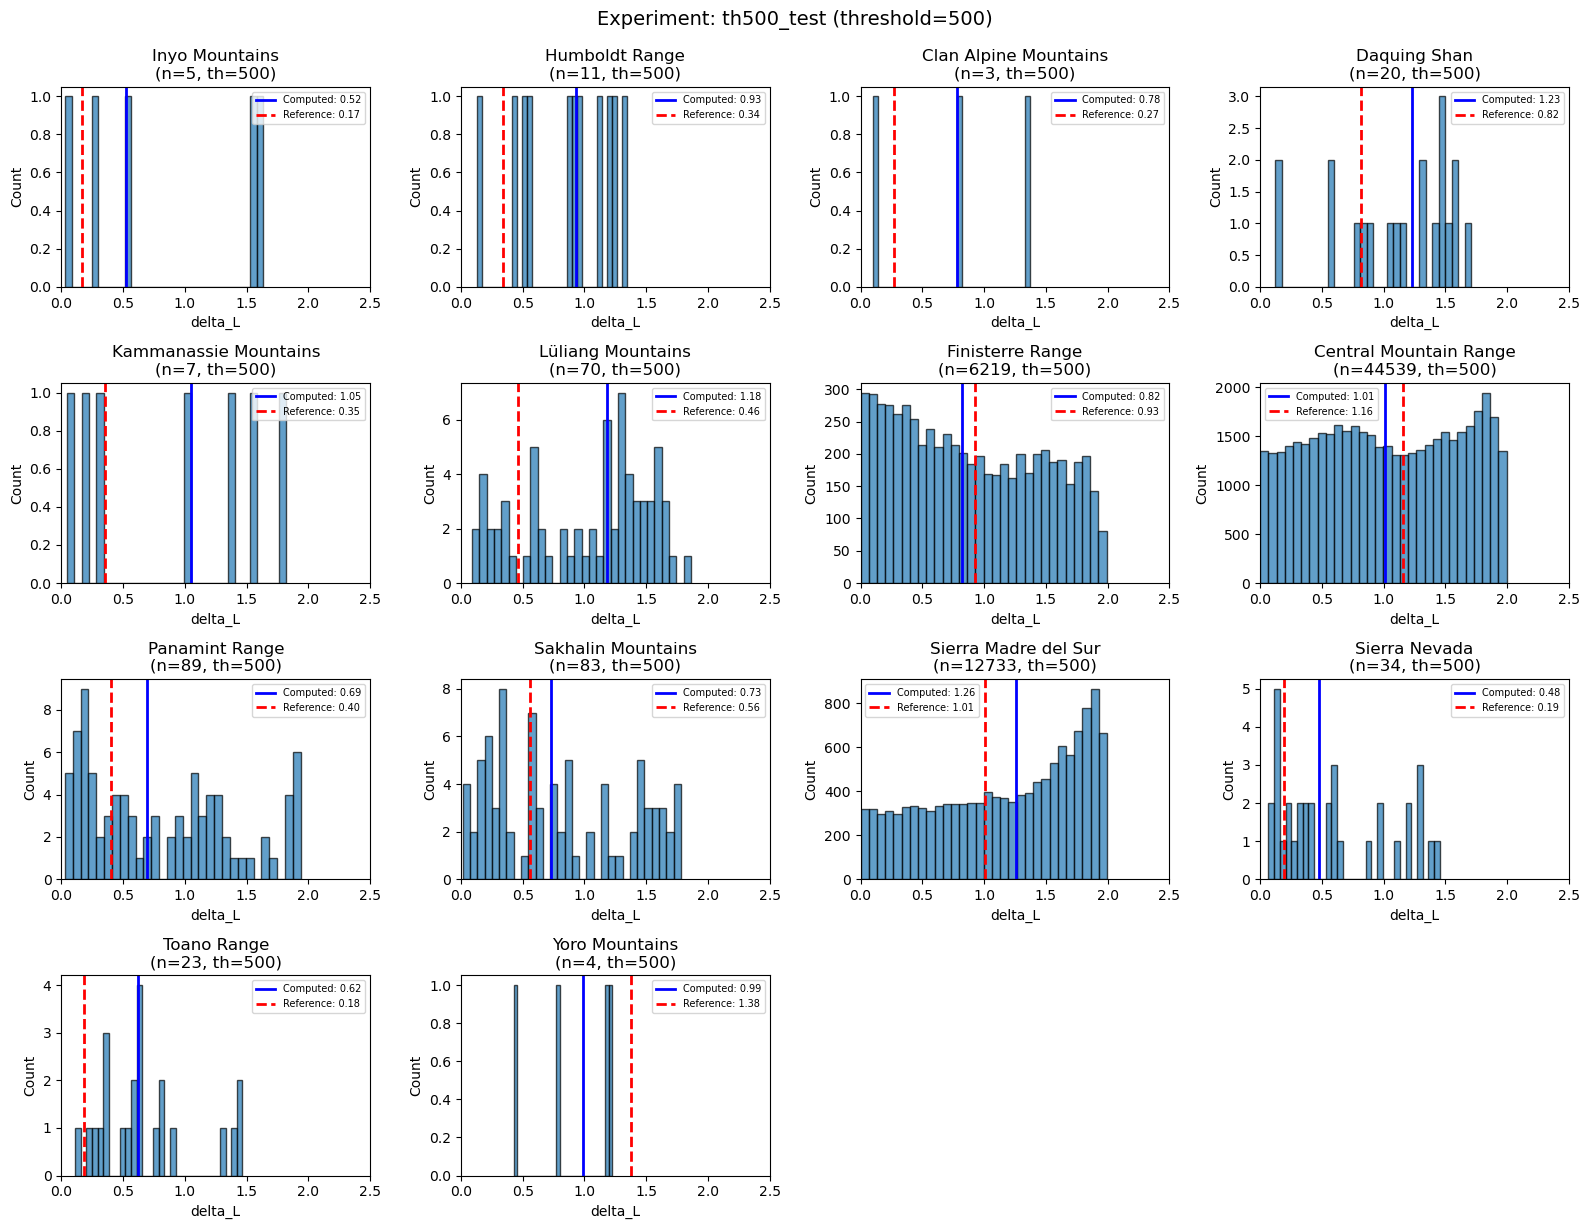

In [7]:
# Plot delta_L distribution for analyzed basins
n_basins = len(basin_results)
if n_basins == 0:
    print("No results to plot")
else:
    n_cols = min(4, n_basins)
    n_rows = (n_basins + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    axes = np.atleast_1d(axes).flatten()
    
    for idx, (basin_name, df) in enumerate(basin_results.items()):
        ax = axes[idx]
        
        if df.empty:
            ax.set_title(f"{basin_name}: No data")
            continue
        
        config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
        ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
        
        delta_L = df['delta_L'].dropna()
        stats = compute_asymmetry_statistics(delta_L)
        
        ax.hist(delta_L, bins=30, alpha=0.7, edgecolor='black')
        ax.axvline(stats['median'], color='blue', linestyle='-', linewidth=2, 
                   label=f'Computed: {stats["median"]:.2f}')
        ax.axvline(ref['median'], color='red', linestyle='--', linewidth=2,
                   label=f'Reference: {ref["median"]:.2f}')
        
        ax.set_xlabel('delta_L')
        ax.set_ylabel('Count')
        short_name = config["full_name"].split(',')[0]
        ax.set_title(f"{short_name}\n(n={len(delta_L)}, th={STREAM_THRESHOLD})")
        ax.legend(fontsize=7)
        ax.set_xlim(0, 2.5)
    
    # Hide unused subplots
    for idx in range(len(basin_results), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle(f'Experiment: {EXPERIMENT_NAME} (threshold={STREAM_THRESHOLD})', y=1.02, fontsize=14)
    
    # Save figure
    fig.savefig(OUTPUT_DIR / "delta_L_distribution.png", dpi=150, bbox_inches='tight')
    print(f"Saved figure to: {OUTPUT_DIR / 'delta_L_distribution.png'}")
    plt.show()

---
## Export Combined Results

---
## Aridity Index vs. Delta-L

Saved figure to: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th500_test/aridity_vs_delta_L.png


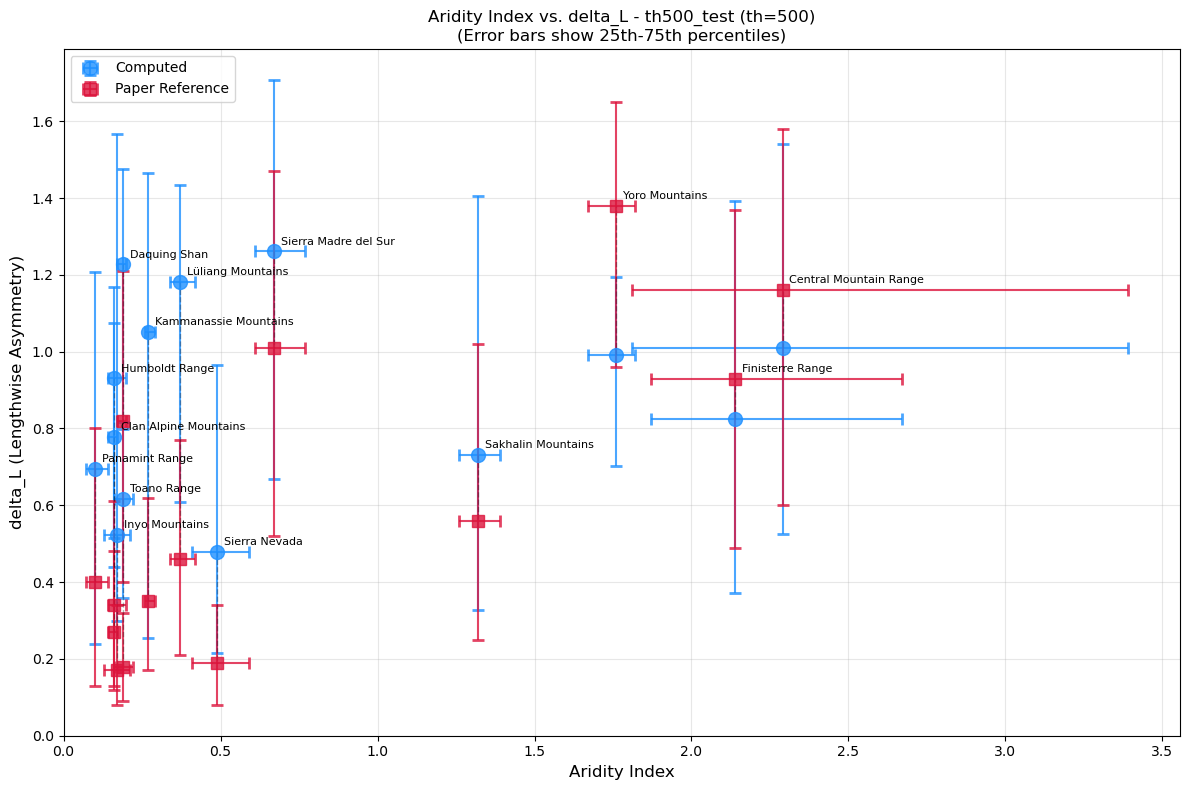

In [8]:
# Scatter plot: Aridity Index vs. Lengthwise Asymmetry (delta_L)
if len(basin_results) == 0:
    print("No results to plot")
else:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Collect data for all analyzed basins
    plot_data = []
    for basin_name, df in basin_results.items():
        if df.empty:
            continue
        
        config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
        ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
        stats = compute_asymmetry_statistics(df['delta_L'].dropna())
        
        plot_data.append({
            "name": config['full_name'].split(',')[0],
            "aridity": config["aridity_index"],
            "aridity_25": config["aridity_index_25"],
            "aridity_75": config["aridity_index_75"],
            "computed_median": stats['median'],
            "computed_25": stats['p25'],
            "computed_75": stats['p75'],
            "ref_median": ref['median'],
            "ref_25": ref['p25'],
            "ref_75": ref['p75'],
        })
    
    # Plot computed values (blue circles)
    for i, d in enumerate(plot_data):
        ax.errorbar(
            d["aridity"], d["computed_median"],
            xerr=[[d["aridity"] - d["aridity_25"]], [d["aridity_75"] - d["aridity"]]],
            yerr=[[d["computed_median"] - d["computed_25"]], [d["computed_75"] - d["computed_median"]]],
            fmt='o', markersize=10, capsize=4, capthick=2,
            color='dodgerblue', ecolor='dodgerblue', alpha=0.8,
            label='Computed' if i == 0 else None
        )
    
    # Plot reference values (red squares)
    for i, d in enumerate(plot_data):
        ax.errorbar(
            d["aridity"], d["ref_median"],
            xerr=[[d["aridity"] - d["aridity_25"]], [d["aridity_75"] - d["aridity"]]],
            yerr=[[d["ref_median"] - d["ref_25"]], [d["ref_75"] - d["ref_median"]]],
            fmt='s', markersize=8, capsize=4, capthick=2,
            color='crimson', ecolor='crimson', alpha=0.8,
            label='Paper Reference' if i == 0 else None
        )
    
    # Connect computed and reference with dashed lines
    for d in plot_data:
        ax.plot([d["aridity"], d["aridity"]], 
                [d["computed_median"], d["ref_median"]], 
                'k--', alpha=0.3, linewidth=1)
    
    # Add labels
    for d in plot_data:
        y_pos = max(d["computed_median"], d["ref_median"])
        ax.annotate(d["name"], (d["aridity"], y_pos),
                    textcoords="offset points", xytext=(5, 5), fontsize=8)
    
    ax.set_xlabel('Aridity Index', fontsize=12)
    ax.set_ylabel('delta_L (Lengthwise Asymmetry)', fontsize=12)
    ax.set_title(f'Aridity Index vs. delta_L - {EXPERIMENT_NAME} (th={STREAM_THRESHOLD})\n'
                 f'(Error bars show 25th-75th percentiles)', fontsize=12)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    
    plt.tight_layout()
    fig.savefig(OUTPUT_DIR / "aridity_vs_delta_L.png", dpi=150, bbox_inches='tight')
    print(f"Saved figure to: {OUTPUT_DIR / 'aridity_vs_delta_L.png'}")
    plt.show()

In [9]:
# Combine all results
all_results = []
for basin_name, df in basin_results.items():
    if df.empty:
        continue
    df_copy = df.copy()
    df_copy['basin'] = basin_name
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    df_copy['basin_full_name'] = config['full_name']
    df_copy['stream_threshold'] = STREAM_THRESHOLD
    df_copy['experiment'] = EXPERIMENT_NAME
    all_results.append(df_copy)

if all_results:
    df_all = pd.concat(all_results, ignore_index=True)
    
    combined_path = OUTPUT_DIR / "all_basins_combined.csv"
    df_all.to_csv(combined_path, index=False)
    
    print(f"\nCombined results saved to: {combined_path}")
    print(f"Total pairs: {len(df_all)}")
    print(f"Total touching: {df_all['touching'].sum()}")
    print(f"Basins: {df_all['basin'].nunique()}")
else:
    print("No results to combine")


Combined results saved to: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th500_test/all_basins_combined.csv
Total pairs: 63840
Total touching: 958
Basins: 14


---
## Experiment Complete

Results have been saved to the experiment output directory. To compare with other experiments:

```python
# Load results from different experiments
import pandas as pd
from channel_heads import get_experiment_output_dir

df_th145 = pd.read_csv(get_experiment_output_dir("th145_baseline") / "all_basins_combined.csv")
df_th500 = pd.read_csv(get_experiment_output_dir("th500_test") / "all_basins_combined.csv")

# Compare delta_L distributions
print(f"Threshold 145: median delta_L = {df_th145['delta_L'].median():.3f}")
print(f"Threshold 500: median delta_L = {df_th500['delta_L'].median():.3f}")
```